# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [1]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import os

print("GRO620 - Problématique")
print("OpenCV version", cv2.__version__)

%matplotlib inline


GRO620 - Problématique
OpenCV version 4.2.0


In [2]:
images_fn = os.listdir("photos_prob/")
print("%i photo(s) à traiter"%(len(images_fn)))
if (len(images_fn) == 0):
    print("ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin.")
    
images = []

for idx, f in enumerate(images_fn):
    img = {"id" : idx}
    img['name'] = f.split('.')[0]
    img['bgr'] = cv2.imread(os.path.join("photos_prob/", f))
    images.append(img)

9 photo(s) à traiter


Affichons maintenant la première image à traiter:

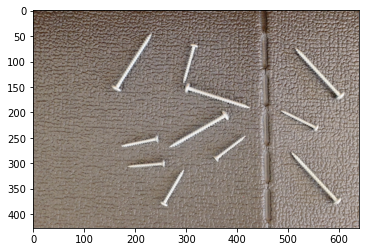

In [3]:
for img in images:
    img['rgb'] = cv2.cvtColor(img['bgr'], cv2.COLOR_BGR2RGB)
    img['gray'] = cv2.cvtColor(img['bgr'], cv2.COLOR_BGR2GRAY)
plt.imshow(images[0]['rgb'])

In [4]:
# Camera params

f_len = 23                 # mm
px_size = 23.4/640         # mm/px
f_len_px = f_len/px_size   # px
W = 640                    # px
H = 427                    # px

K = np.array([[f_len_px,       0., W],
              [      0., f_len_px, H],
              [      0.,       0., 1.]
])

Tc = np.array([[0., 1.,  0., 500],  # mm
               [1., 0.,  0., 200],
               [0., 0., -1., 282],
               [0., 0.,  0.,  1.]  
])


(0.0, 256.0)

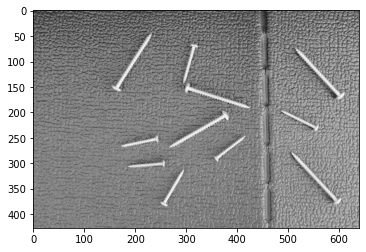

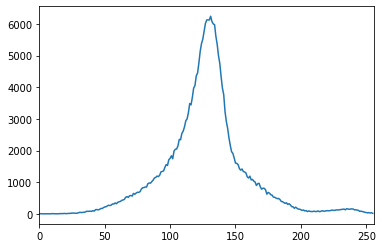

In [5]:

hist = cv2.calcHist([images[0]['gray']], [0], None, [256], [0,256])

plt.figure()
plt.imshow(images[0]['gray'], cmap='gray')

plt.figure()
plt.plot(hist)
plt.xlim([0,256])


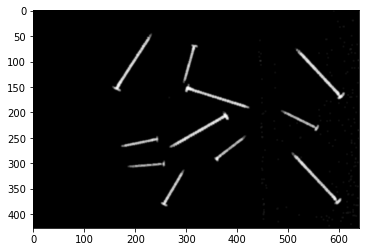

In [6]:
for img in images:
    
    # Threshold and bluring
    ret, thresh = cv2.threshold(img['gray'], 200, 255, cv2.THRESH_BINARY)
    img_blur = cv2.GaussianBlur(thresh, (5, 5), 0)

    # Erosion and dilation to remove small white spots
    kernel = np.ones((3,3), np.uint8)  
    img_erosion = cv2.erode(img_blur, kernel, iterations=1) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    img['bw'] = img_dilation
    
plt.imshow(images[0]['bw'], cmap='gray')

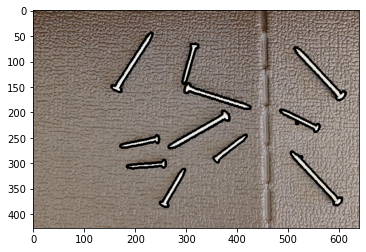

In [7]:
for img in images:
    
    contours, hierarchy = cv2.findContours(img['bw'], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    screw_cnt = []
    for c in contours:
        
        # Filter by area
        area = cv2.contourArea(c)
        if area < 200:
            continue
        
        # Filter partial detections
        partial = False
        tol = 3
        for p in c:
            if p[0][0] < tol or p[0][0] > W-1-tol or p[0][1] < tol or p[0][1] == H-1-tol:
                partial = True 
        
        if not partial:
            screw_cnt.append(c)
            
    img['cnt'] = cv2.drawContours(img['rgb'].copy(), screw_cnt, -1, (0,0,0), 3)
    img['screw_cnt'] = screw_cnt

plt.imshow(images[0]['cnt'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f571c2267c0>,
 <matplotlib.image.AxesImage at 0x7f571c18b3d0>)

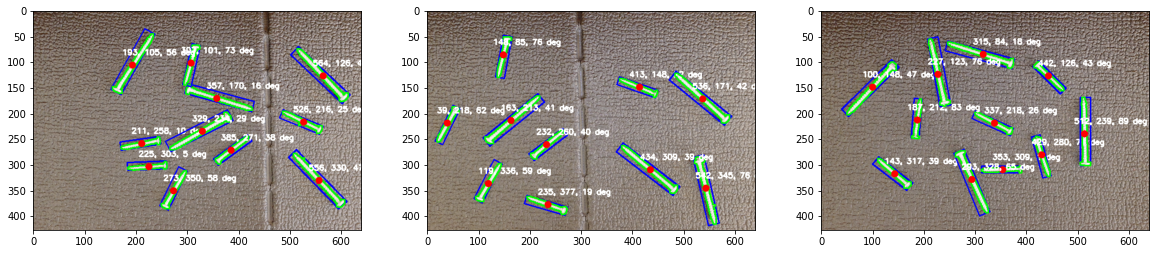

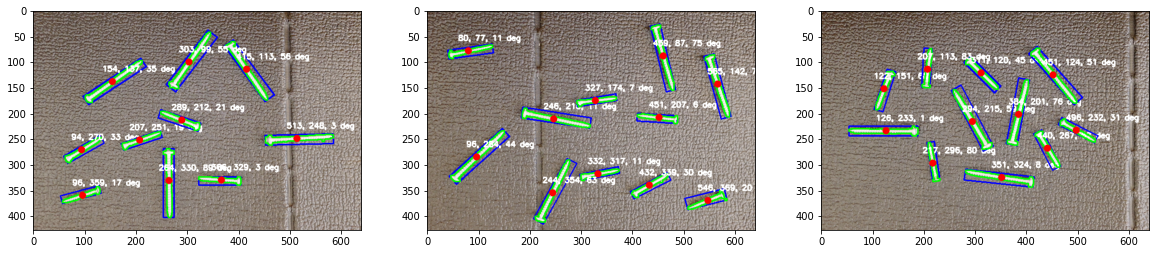

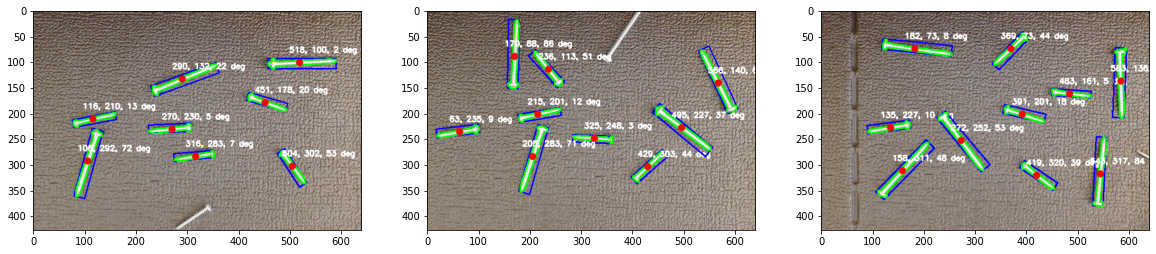

In [8]:
# Find screws information
for img in images:

    img['detections'] = img['rgb'].copy()
    screws = []

    for idx, c in enumerate(img['screw_cnt']):

        # Bounding box
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)        
        img['detections'] = cv2.drawContours(img['detections'],[box],0,(0,0,255),2)

        # Center of contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # Find angle
        vx, vy, x, y = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01)
        angle = np.arctan2(np.abs(vy), np.abs(vx))

        # Find lenght of screw
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius)
        length = 2*radius*px_size
        screw_type = 'short' if length < 4 else 'long'
        # To draw circle
        # cv2.circle(img['detections'],center,radius,(0,255,0),2)

        # Draw on image
        cv2.drawContours(img['detections'], [c], -1, (0, 255, 0), 2)
        cv2.circle(img['detections'], (cX, cY), 7, (255, 0, 0), -1)
        cv2.putText(img['detections'], str(cX) + ", " + str(cY) + ", " + str(int(angle*180/np.pi)) + " deg", 
                    (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        screws.append({'id': idx,
                       'pixel_x': cX, 
                       'pixel_y': cY,
                       'len': length,
                       'angle': angle,
                       'type': screw_type})
    
    img['screws'] = screws

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[0]['detections'])
plt.subplot(132),plt.imshow(images[1]['detections'])
plt.subplot(133),plt.imshow(images[2]['detections'])

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[3]['detections'])
plt.subplot(132),plt.imshow(images[4]['detections'])
plt.subplot(133),plt.imshow(images[5]['detections'])

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[6]['detections'])
plt.subplot(132),plt.imshow(images[7]['detections'])
plt.subplot(133),plt.imshow(images[8]['detections'])


In [9]:
# Transform pixel coordinates to 3D coordinates

# Find Projection matrix
T = np.linalg.inv(Tc)
Rt = T[0:3, :]
P = np.dot(K, Rt)

print('P matrix : ')
print(P)

# Find P tilde
Pt = np.zeros([4, 4])
Pt[0:3, 0:4] = P[0:3, 0:4]
Pt[3, 0:4] = np.array([0, 0, 0, 1])

for img in images:
    
    for screw in img['screws']:
        point_c = np.array([screw['pixel_x'], screw['pixel_y'], 0, 1])
        point_0 = np.dot(Pt, point_c)
        point_0 = point_0/point_0[2]
        screw['coords'] = (point_0[0], point_0[1], 0)


P matrix : 
[[ 0.00000000e+00  6.29059829e+02 -6.40000000e+02  5.46680342e+04]
 [ 6.29059829e+02  0.00000000e+00 -4.27000000e+02 -1.94115915e+05]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  2.82000000e+02]]


In [10]:
# Output CSV files

for img in images:
    with open('./csv/' + img['name'] + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Type", "X (m)", "Y (m)", "Z (m)", "Theta (rad)"])
        for screw in img['screws']:
            writer.writerow([screw['id'], screw['type'], "%.2f"%screw['coords'][0], 
                             "%.2f"%screw['coords'][1], "%.2f"%screw['coords'][2], 
                             "%.3f"%screw['angle']])